# Convert a PaddlePaddle Model to OpenVINOâ„¢ IR

This notebook shows how to convert a MobileNetV3 model from [PaddleHub](https://github.com/PaddlePaddle/PaddleHub), pre-trained on the [ImageNet](https://www.image-net.org) dataset, to OpenVINO IR. It also shows how to perform classification inference on a sample image, using [OpenVINO Runtime](https://docs.openvino.ai/nightly/openvino_docs_OV_UG_OV_Runtime_User_Guide.html) and compares the results of the [PaddlePaddle](https://github.com/PaddlePaddle/Paddle) model with the IR model.

Source of the [model](https://www.paddlepaddle.org.cn/hubdetail?name=mobilenet_v3_large_imagenet_ssld&en_category=ImageClassification).

## Preparation

### Imports

In [1]:
import sys

if sys.version_info.minor > 7:
    !pip install -q "paddlepaddle==2.5.0rc0"
else:
    !pip install -q "paddlepaddle==2.4.2"


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -q paddleclas --no-deps
!pip install -q "prettytable" "ujson" "visualdl>=2.2.0" "faiss-cpu>=1.7.1"


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleclas 2.5.1 requires faiss-cpu==1.7.1.post2, but you have faiss-cpu 1.7.4 which is incompatible.
paddleclas 2.5.1 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import time
import tarfile
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from paddleclas import PaddleClas
from PIL import Image
from openvino.runtime import Core
sys.path.append("../utils")
from notebook_utils import download_file

2023-06-20 14:10:19 INFO: Loading faiss with AVX2 support.
2023-06-20 14:10:19 INFO: Successfully loaded faiss with AVX2 support.


### Settings

Set `IMAGE_FILENAME` to the filename of an image to use. Set `MODEL_NAME` to the PaddlePaddle model to download from PaddleHub. `MODEL_NAME` will also be the base name for the IR model. The notebook is tested with the [mobilenet_v3_large_x1_0](https://github.com/PaddlePaddle/PaddleClas/blob/release/2.5/docs/en/models/Mobile_en.md) model. Other models may use different preprocessing methods and therefore require some modification to get the same results on the original and converted model.

First of all, we need to download and unpack model files.
The first time you run this notebook, the PaddlePaddle model is downloaded from PaddleHub. This may take a while.

In [4]:
IMAGE_FILENAME = "../data/image/coco_close.png"

MODEL_NAME = "MobileNetV3_large_x1_0"
MODEL_DIR = Path("model")
if not MODEL_DIR.exists():
    MODEL_DIR.mkdir()
MODEL_URL = 'https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/inference/{}_infer.tar'.format(MODEL_NAME)
download_file(MODEL_URL, directory=MODEL_DIR)
file = tarfile.open(MODEL_DIR / '{}_infer.tar'.format(MODEL_NAME))
res = file.extractall(MODEL_DIR)
if not res:
    print(f"Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the model. Please check the network.")

'model/MobileNetV3_large_x1_0_infer.tar' already exists.
Model Extracted to "./model".


## Show Inference on PaddlePaddle Model

In the next cell, we load the model, load and display an image, do inference on that image, and then show the top three prediction results.

[2023/06/20 14:10:23] ppcls WARNING: The current running environment does not support the use of GPU. CPU has been used instead.


W0620 14:10:23.619710 156011 analysis_config.cc:971] It is detected that mkldnn and memory_optimize_pass are enabled at the same time, but they are not supported yet. Currently, memory_optimize_pass is explicitly disabled


Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


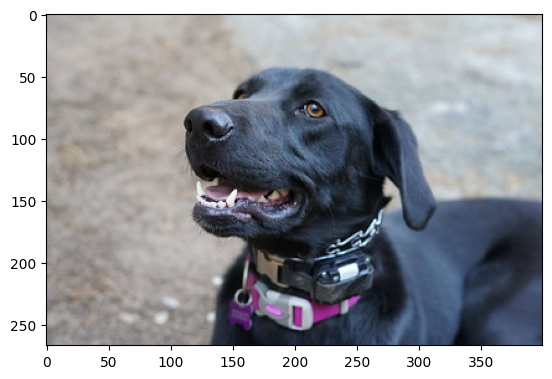

In [5]:
classifier = PaddleClas(inference_model_dir=MODEL_DIR / '{}_infer'.format(MODEL_NAME))
result = next(classifier.predict(IMAGE_FILENAME))
class_names = result[0]['label_names']
scores = result[0]['scores']
image = Image.open(IMAGE_FILENAME)
plt.imshow(image)
for class_name, softmax_probability in zip(class_names, scores):
    print(f"{class_name}, {softmax_probability:.5f}")

`classifier.predict()` takes an image file name, reads the image, preprocesses the input, then returns the class labels and scores of the image. Preprocessing the image is done behind the scenes. The classification model returns an array with floating point values for each of the 1000 ImageNet classes. The higher the value, the more confident the network is that the class number corresponding to that value (the index of that value in the network output array) is the class number for the image.

To see PaddlePaddle's implementation for the classification function and for loading and preprocessing data, uncomment the next two cells.

In [6]:
# classifier??

In [7]:
# classifier.get_config()

The `classifier.get_config()` module shows the preprocessing configuration for the model. It should show that images are normalized, resized and cropped, and that the BGR image is converted to RGB before propagating it through the network. In the next cell, we get the `classifier.predictror.preprocess_ops` property that returns list of preprocessing operations to do inference on the OpenVINO IR model using the same method.

In [8]:
preprocess_ops = classifier.predictor.preprocess_ops


def process_image(image):
    for op in preprocess_ops:
        image = op(image)
    return image

It is useful to show the output of the `process_image()` function, to see the effect of cropping and resizing. Because of the normalization, the colors will look strange, and matplotlib will warn about clipping values.

2023-06-20 14:10:24 WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processed image shape: (3, 224, 224)


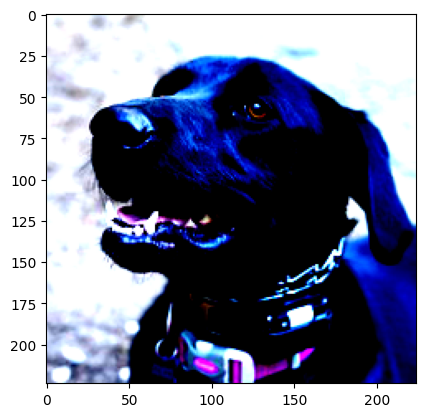

In [9]:
pil_image = Image.open(IMAGE_FILENAME)
processed_image = process_image(np.array(pil_image))
print(f"Processed image shape: {processed_image.shape}")
# Processed image is in (C,H,W) format, convert to (H,W,C) to show the image
plt.imshow(np.transpose(processed_image, (1, 2, 0)))

To decode the labels predicted by the model to names of classes, we need to have a mapping between them. The model config contains information about `class_id_map_file`, which stores such mapping. The code below shows how to parse the mapping into a dictionary to use with the OpenVINO model.

In [10]:
class_id_map_file = classifier.get_config()['PostProcess']['Topk']['class_id_map_file']
class_id_map = {}
with open(class_id_map_file, "r") as fin:
    lines = fin.readlines()
    for line in lines:
        partition = line.split("\n")[0].partition(" ")
        class_id_map[int(partition[0])] = str(partition[-1])

## Convert the Model to OpenVINO IR Format

Call the OpenVINO Model Optimizer Python API to convert the PaddlePaddle model to OpenVINO IR, with FP32 precision. `mo.convert_model` function accept path to PaddlePaddle model and returns OpenVINO Model class instance which represents this model. Obtained model is ready to use and loading on device using `compile_model` or can be saved on disk using `serialize` function.
See the [Model Optimizer Developer Guide](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

In [11]:
from openvino.tools import mo
from openvino.runtime import serialize

model_xml = Path(MODEL_NAME).with_suffix('.xml')
if not model_xml.exists():
    ov_model = mo.convert_model("model/MobileNetV3_large_x1_0_infer/inference.pdmodel")
    serialize(ov_model, str(model_xml))
else:
    print(f"{model_xml} already exists.")

MobileNetV3_large_x1_0.xml already exists.


## Show Inference on OpenVINO Model

Load the IR model, get model information, load the image, do inference, convert the inference to a meaningful result, and show the output. See the [OpenVINO Runtime API Notebook](../002-openvino-api/002-openvino-api.ipynb) for more information.

Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848


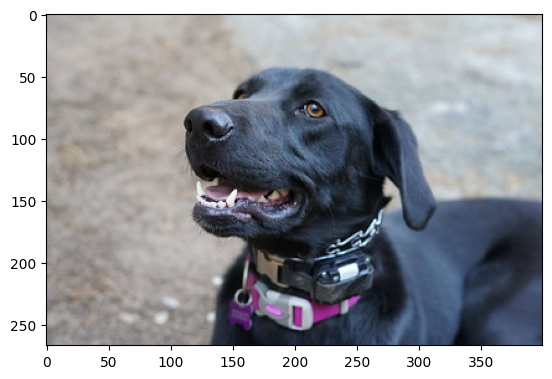

In [12]:
# Load OpenVINO Runtime and OpenVINO IR model
ie = Core()
model = ie.read_model(model_xml)
compiled_model = ie.compile_model(model=model, device_name="CPU")

# Get model output
output_layer = compiled_model.output(0)

# Read, show, and preprocess input image
# See the "Show Inference on PaddlePaddle Model" section for source of process_image
image = Image.open(IMAGE_FILENAME)
plt.imshow(image)
input_image = process_image(np.array(image))[None,]

# Do inference
ie_result = compiled_model([input_image])[output_layer][0]

# find the top three values
top_indices = np.argsort(ie_result)[-3:][::-1]
top_scores = ie_result[top_indices]

# Convert the inference results to class names, using the same labels as the PaddlePaddle classifier
for index, softmax_probability in zip(top_indices, top_scores):
    print(f"{class_id_map[index]}, {softmax_probability:.5f}")

## Timing and Comparison

Measure the time it takes to do inference on fifty images and compare the result. The timing information gives an indication of performance. For a fair comparison, we include the time it takes to process the image. For more accurate benchmarking, use the [OpenVINO benchmark tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html). Note that many optimizations are possible to improve the performance.

In [13]:
num_images = 50

image = Image.open(fp=IMAGE_FILENAME)

In [14]:
# Show CPU information
ie = Core()
print(f"CPU: {ie.get_property('CPU', 'FULL_DEVICE_NAME')}")

CPU: Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz


PaddlePaddle model on CPU: 0.0077 seconds per image, FPS: 129.65

PaddlePaddle result:
Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


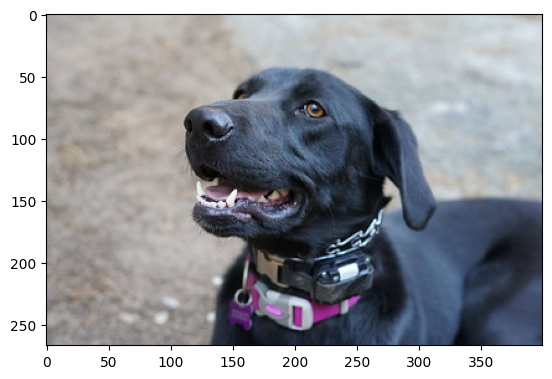

In [15]:
# Show inference speed on PaddlePaddle model
start = time.perf_counter()
for _ in range(num_images):
    result = next(classifier.predict(np.array(image)))
end = time.perf_counter()
time_ir = end - start
print(
    f"PaddlePaddle model on CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}\n"
)
print("PaddlePaddle result:")
class_names = result[0]['label_names']
scores = result[0]['scores']
for class_name, softmax_probability in zip(class_names, scores):
    print(f"{class_name}, {softmax_probability:.5f}")
plt.imshow(image);

OpenVINO IR model in OpenVINO Runtime (CPU): 0.0027 seconds per image, FPS: 370.02

OpenVINO result:
Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


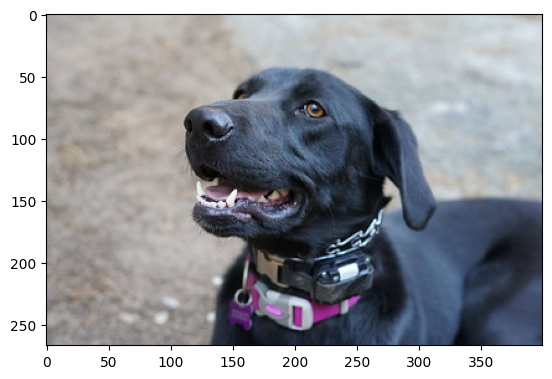

In [16]:
# Show inference speed on OpenVINO IR model
compiled_model = ie.compile_model(model=model, device_name="CPU")
output_layer = compiled_model.output(0)


start = time.perf_counter()
input_image = process_image(np.array(image))[None,]
for _ in range(num_images):
    ie_result = compiled_model([input_image])[output_layer][0]
    top_indices = np.argsort(ie_result)[-5:][::-1]
    top_softmax = ie_result[top_indices]

end = time.perf_counter()
time_ir = end - start

print(
    f"OpenVINO IR model in OpenVINO Runtime (CPU): {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)
print()
print("OpenVINO result:")
for index, softmax_probability in zip(top_indices, top_softmax):
    print(f"{class_id_map[index]}, {softmax_probability:.5f}")
plt.imshow(image);

## References

* [PaddleClas](https://github.com/PaddlePaddle/PaddleClas)
* [OpenVINO PaddlePaddle support](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_Paddle.html)
* [OpenVINO Model Optimizer Documentation](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model_General.html)